# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras==2.3.1

# аугментации изображений
#!pip install albumentations -q

# Лемматизация текста
#!pip install pymystem3

In [2]:
# Загрузка библиотек

from tqdm.notebook import tqdm
import os
import sys
import random
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats import weightstats
import PIL
import cv2
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from gensim.models import FastText
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

tqdm.pandas()

Using TensorFlow backend.
C:\Users\79262\anaconda3\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [4]:
# Целевая метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

# Первичный взгляд на данные

In [7]:
# Загрузка данных в переменные
#DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
#train = pd.read_csv(DATA_DIR + 'train.csv')
#test = pd.read_csv(DATA_DIR + 'test.csv')
#sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
pd.options.display.max_columns = train.shape[1]
display(train.head())
display(train.info())

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

None

In [9]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [10]:
pd.options.display.max_columns = test.shape[1]
display(test.head())
display(test.info())

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

None

In [11]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

**Посмотрим на типы признаков:**

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [12]:
sample_submission.sample(5)

,sell_id,price
438,1100031984,0
570,1095236030,0
567,1100194940,0
534,1099664178,0
1616,1099992028,0


Тренировочная и тестовая выборки представлены в одинаковом формате, можно их обрабатывать совместно. Много пропусков в признаке "Владение" и один пропуск признака "Владельцы" в тренировочной выборке.

# Предобработка

In [13]:
# Объединение выборок
train['train'] = 1
test['train'] = 0
test['price'] = 0.0
data = pd.concat([train, test], ignore_index=True)
del train, test

In [14]:
pd.options.display.max_columns = data.shape[1]
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый,1
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый,1
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый,1


## Извлечение дополнительных признаков

In [15]:
# Фунция возвращает время владения в месяцах
def get_own_time(string):
    months = 0
    if type(string) == str:
        numbers = re.findall(r'\d+', string)
        if len(numbers) == 2:
            months += int(numbers[0])*12 + int(numbers[1])
        else:
            if 'месяц' in string:
                months += int(numbers[0])
            else:
                months += int(numbers[0])*12
    return months


# Фунция возвращает объем двигателя
def get_eng_volume(string):
    try:
        return float('0'+string[:str.find(string, ' ')])
    except:
        return None

In [16]:
# Объем двигателя
data['eng_volume'] = data['engineDisplacement'].progress_apply(get_eng_volume)

# Мощность двигателя
data['eng_pwr'] = data['enginePower'].apply(
    lambda x: int(x[:str.find(x, ' ')]))

# Время владения
data['own_time'] = data['Владение'].apply(get_own_time)

data.sample(3)

  0%|          | 0/8353 [00:00<?, ?it/s]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
7593,купе,BMW,синий,Салон: 9. Обзор: 8. Мультимедиа: 3. Комфорт: 5...,2.0 LTR,184 N12,бензин,63400,2013,4,420i xDrive 2.0 AT (184 л.с.) 4WD,...,COUPE AUTOMATIC 2.0,автоматическая,1 владелец,3 года и 11 месяцев,Оригинал,полный,Левый,0,2.0,184,47
6919,внедорожник 5 дв.,BMW,серебристый,ПРИ ПОКУПКЕ В TRADE-IN ВЫГОДА ОТ 20 ДО 70 ТЫСЯ...,4.8 LTR,360 N12,бензин,198000,2003,X5,4.8is 4.8 AT (360 л.с.) 4WD,...,ALLROAD_5_DOORS AUTOMATIC 4.8,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,4.8,360,0
345,седан,AUDI,чёрный,Автомобиль покупался новым у официального дил...,3.0 LTR,310 N12,бензин,86000,2013,A8,3.0 AT (310 л.с.) 4WD,...,SEDAN AUTOMATIC 3.0,автоматическая,1 владелец,4 года и 6 месяцев,Оригинал,полный,Левый,1,3.0,310,54


In [17]:
# Проверка авто с неопределенным объемом двигателя
pd.options.display.max_columns = data.shape[1]
data[data.eng_volume.isna() == True]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
2296,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,S Electro AT (136 кВт),5,2719000.0,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,184,0
3725,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,Electro AT (126 кВт),5,2299711.0,2017,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,NaN,170,35
3726,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,Electro AT (126 кВт),5,2170000.0,2017,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
5862,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,Electro AT (126 кВт),5,1690000.0,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
6283,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,Electro AT (126 кВт),5,1790000.0,2015,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
7687,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,Electro AT (126 кВт),5,0.0,2014,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,NaN,170,0


У электромобилей не определен объем двигателя. Заменим NaN на 0


In [18]:
data.eng_volume.fillna(0.0, inplace=True)

In [19]:
# Убираем ненужные колонки
data.drop(['engineDisplacement', 'enginePower', 'name',
           'vehicleConfiguration', 'Владение'], axis=1, inplace=True)

In [20]:
# Распределим переменные по типу

bin_cols = ['ПТС', 'Руль']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'model_info', 'vehicleTransmission', 'Владельцы', 'Привод']
dat_cols = []
num_cols = ['mileage', 'modelDate', 'numberOfDoors', 'price',
            'productionDate', 'eng_volume', 'eng_pwr', 'own_time']

# Model 1: Наивная модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.


In [21]:
# Функция возвращает MAPE, MAE и MSE
def metrics(true, preds):
    output = []
    output.append(mape(true, preds))
    output.append(mean_absolute_error(true, preds))
    output.append(mean_squared_error(true, preds)**(1/2))
    return output

In [22]:
# Наивная модель
train, test = train_test_split(
    data[data.train == 1], test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
preds = []
for index, row in pd.DataFrame(test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    preds.append(train.query(query)['price'].median())

# Заполним не найденные совпадения
preds = pd.DataFrame(preds)
preds = preds.fillna(preds.median())

# Округление
preds = (preds // 1000) * 1000

# Результат
pd.set_option('display.float_format', lambda x: '%.4f' % x)

results = pd.DataFrame({'naive': metrics(test['price'], preds[0].values)},
                       index=['MAPE', 'MAE', 'RMSE'])
results

,naive
MAPE,0.1988
MAE,347328.2433
RMSE,932296.7579


Точность наивной модели по метрике MAPE: 19.88%

# EDA

## Бинарные признаки

In [23]:
# Функция, проверяющая наличие статистически значимых различий между вариациями признака
def get_stat_dif(df, col, target):
    variations = len(df[col].value_counts().index)
    indexes = [i for i in range(0, variations)]
    comb = list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]][target]
        y = df[df[col] == df[col].value_counts().index[c[1]]][target]
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            return True
        else:
            return False

In [24]:
# Функция выводит основную информацию, визуализацию пропорций в тренировочной выборке и сравнении с тестовой
def sum_up_cat(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label] == 1]
    trn = train[col].value_counts(normalize=True)
    tst = df[df[label] == 0][col].value_counts(normalize=True)
    vc = train[col].value_counts()
    changes = pd.DataFrame({'train': trn, 'test': tst})
    for i in vc.index:
        print('{} (%%):\t{}'.format(i, np.round(trn[i], 2)))
        print('\t Среднее значение целевой:\t{}'.format(
            np.round(train[train[col] == i][target].mean(), 2)))
    print('Cтатистически значимые различия:\t{}'.format(
        get_stat_dif(train, col, target)))
    fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
    sns.barplot(x=vc.index, y=vc.values, palette='viridis', ax=axs[0])
    if len(train[col].unique()) > 5:
        axs[0].tick_params(labelrotation=45)
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[1])
    if len(changes.index) > 5:
        axs[1].tick_params(labelrotation=45)
    plt.show()

ПТС
Оригинал (%%):	0.89
	 Среднее значение целевой:	1997735.95
Дубликат (%%):	0.11
	 Среднее значение целевой:	1079262.84
Cтатистически значимые различия:	True


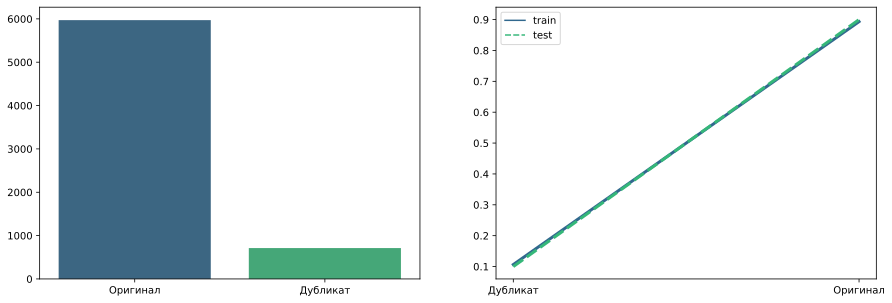

РУЛЬ
Левый (%%):	1.0
	 Среднее значение целевой:	1900145.02
Правый (%%):	0.0
	 Среднее значение целевой:	975000.0
Cтатистически значимые различия:	False


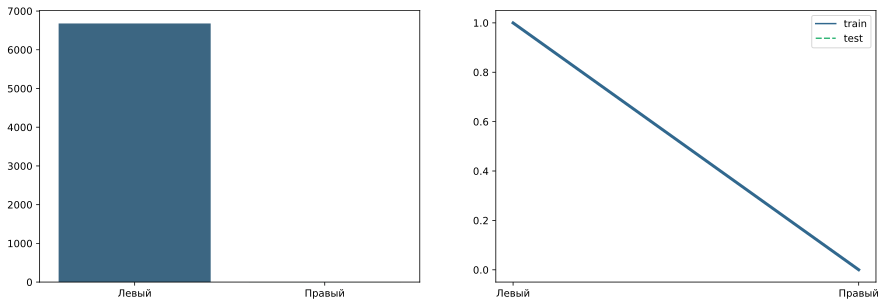

In [25]:
for column in bin_cols:
    sum_up_cat(data, column, 'price')

Распределение признака "ПТС" сходно в тренировочной и тестовой выборках.
Количество автомобилей с правым рулем очень мало, стоит рассмотреть эти автомобили более внимательно.

In [26]:
data[data['Руль'] == 'Правый']

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
1107,купе,AUDI,красный,"Эксклюзивное авто, собрано в Японии. Правый ру...",бензин,173160,2003,TT,2,450000.0000,2004,1098344588,автоматическая,3 или более,Дубликат,передний,Правый,1,1.8000,180,0
1517,компактвэн,BMW,синий,"Продам автомобиль, сборка Мюнхен, Бавария, экс...",дизель,43000,2015,2GRANDTOURER,5,1500000.0000,2016,1091158456,автоматическая,1 владелец,Оригинал,передний,Правый,1,2.0000,150,15


In [27]:
data.loc[1107]['description']

'Эксклюзивное авто, собрано в Японии. Правый руль. Внимание на дороге обеспечено. \nЕзжу на ней 9 лет. \nТолько в хорошие руки\nБЕЗ ТОРГА! Если не продам за 450, буду сама с удовольствием ездить ещё 10 лет! '

In [28]:
data.loc[1517]['description']

'Продам автомобиль, сборка Мюнхен, Бавария, экспортный вариант, люксовый вариант,  комплектация для этой модели максимальная. Произведена 15.12.2016, привезена из Японии в 2019г. . Оптимальный семейный автомобиль. . Причина продажи — для моей семьи маловат.'

Для рассматриваемого датасета признак "Руль" или не будет иметь значения или, наоборот, создаст ненужные искажения. Удалим признак.

In [29]:
data.drop('Руль', axis=1, inplace=True)
bin_cols.remove('Руль')

## Категориальные признаки

### Признаки с небольшим количеством уникальных значений

BRAND
BMW (%%):	0.42
	 Среднее значение целевой:	1718737.56
MERCEDES (%%):	0.34
	 Среднее значение целевой:	2580641.74
AUDI (%%):	0.24
	 Среднее значение целевой:	1234281.59
Cтатистически значимые различия:	True


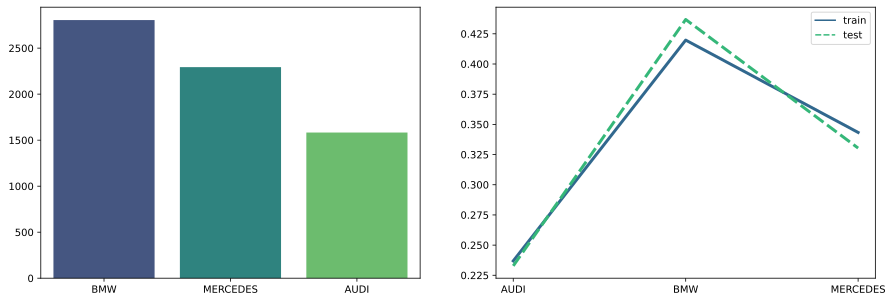

FUELTYPE
бензин (%%):	0.72
	 Среднее значение целевой:	1735909.59
дизель (%%):	0.28
	 Среднее значение целевой:	2317971.73
гибрид (%%):	0.0
	 Среднее значение целевой:	2599583.33
электро (%%):	0.0
	 Среднее значение целевой:	2133742.2
Cтатистически значимые различия:	True


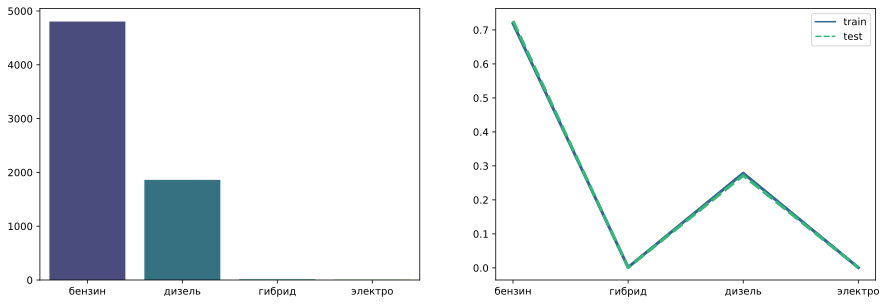

VEHICLETRANSMISSION
автоматическая (%%):	0.79
	 Среднее значение целевой:	2046798.74
роботизированная (%%):	0.14
	 Среднее значение целевой:	1647541.07
вариатор (%%):	0.05
	 Среднее значение целевой:	679936.38
механическая (%%):	0.02
	 Среднее значение целевой:	917805.67
Cтатистически значимые различия:	True


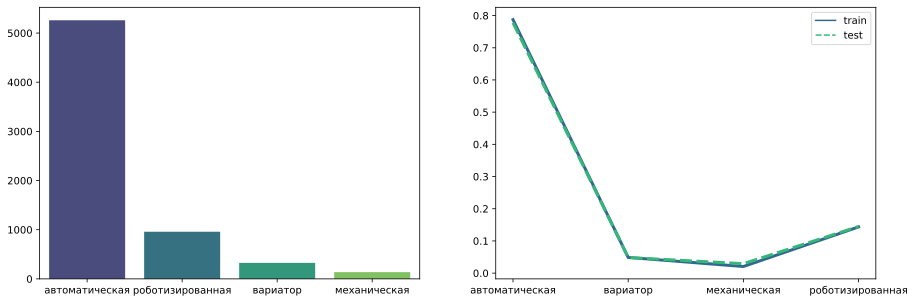

ВЛАДЕЛЬЦЫ
3 или более (%%):	0.4
	 Среднее значение целевой:	1172520.13
1 владелец (%%):	0.3
	 Среднее значение целевой:	2920771.18
2 владельца (%%):	0.3
	 Среднее значение целевой:	1827310.95
Cтатистически значимые различия:	True


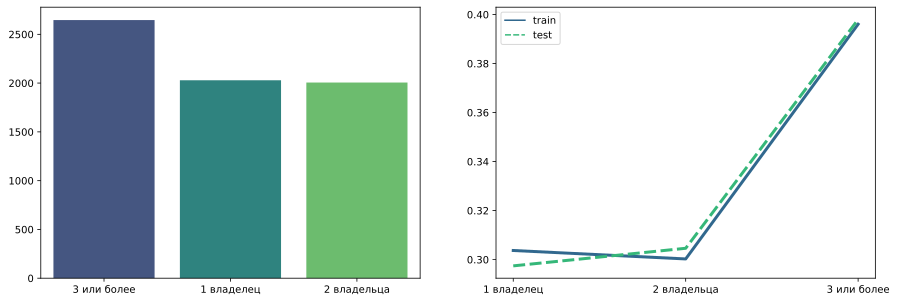

ПРИВОД
полный (%%):	0.63
	 Среднее значение целевой:	2291359.28
задний (%%):	0.27
	 Среднее значение целевой:	1373554.29
передний (%%):	0.11
	 Среднее значение целевой:	907187.13
Cтатистически значимые различия:	True


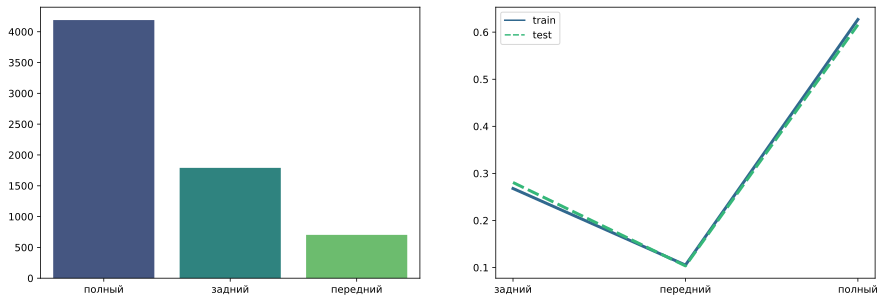

In [30]:
# Число уникальных значений меньше 10
for column in cat_cols:
    if len(data[column].unique()) <= 10:
        sum_up_cat(data, column, 'price')

Для рассмотренных переменных найдены статистически значимые различия.

Распределение признаков, в целом, совпадает в тестовой и тренировочной выборках

В тренировочной выборке есть один автомобиль с пропущенным признаком "Владельцы", рассмотрим его отдельно.

In [31]:
data[data['Владельцы'].isna() == True]

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,бензин,160000,1999,S8,4,600000.0000,2001,1019330519,автоматическая,NaN,Оригинал,полный,1,4.2000,360,127


In [32]:
# Заполним пропуск наиболее популярным значением для автомобилей этого бренда и года выпуска
data.loc[4994]['Владельцы'] = data[(data.brand == 'AUDI') & (
    data.modelDate == 1999)]['Владельцы'].value_counts().index[0]

<ipython-input-32-8e0a674d0de5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[4994]['Владельцы'] = data[(data.brand == 'AUDI') & (


### Признаки с большим количеством уникальных значений

In [33]:
# Проверка наличия статистически значимых различий для переменных с большим числом уникальных значений
for column in cat_cols:
    if len(data[column].unique()) > 10:
        print(column.upper())
        print('Cтатистически значимые различия:\t{}'.format(
            get_stat_dif(data[data.train == 1], column, 'price')))

BODYTYPE
Cтатистически значимые различия:	True
COLOR
Cтатистически значимые различия:	True
MODEL_INFO
Cтатистически значимые различия:	True


Статистически значимые различия есть

## Числовые признаки

In [34]:
# Функция рассчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest) | (df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [35]:
# Функция выводит основную информацию и график признака
def sum_up_num(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label] == 1]
    trn = train[col].describe()[1:]
    tst = df[df[label] == 0][col].describe()[1:]
    changes = pd.DataFrame({'train': trn, 'test': tst})

    print(trn)
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(train, col)[0],
                                                   np.round(outbursts(train, col)[1]*100, 2)))
    print()
    fig, axs = plt.subplots(figsize=(20, 5), ncols=3)
    sns.distplot(train[col], kde=True, ax=axs[0])
    sns.boxplot(data=train,  x=col, palette='viridis', ax=axs[1])
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[2])
    plt.show()

MILEAGE
mean   120522.6109
std     81454.4483
min         1.0000
25%     59181.2500
50%    111000.0000
75%    168000.0000
max    999999.0000
Name: mileage, dtype: float64
Кол-во выбросов: 113 	 (%%: 1.69)



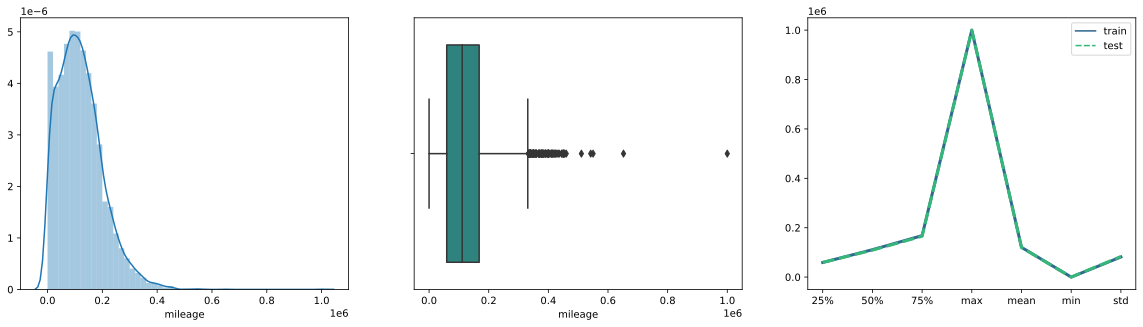

MODELDATE
mean   2010.1356
std       5.3710
min    1975.0000
25%    2007.0000
50%    2011.0000
75%    2014.0000
max    2019.0000
Name: modelDate, dtype: float64
Кол-во выбросов: 143 	 (%%: 2.14)



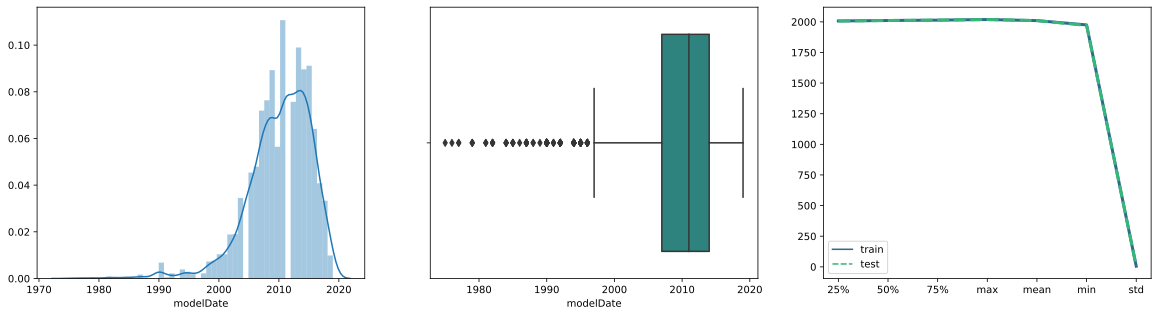

NUMBEROFDOORS
mean   4.2685
std    0.8787
min    2.0000
25%    4.0000
50%    4.0000
75%    5.0000
max    5.0000
Name: numberOfDoors, dtype: float64
Кол-во выбросов: 627 	 (%%: 9.38)



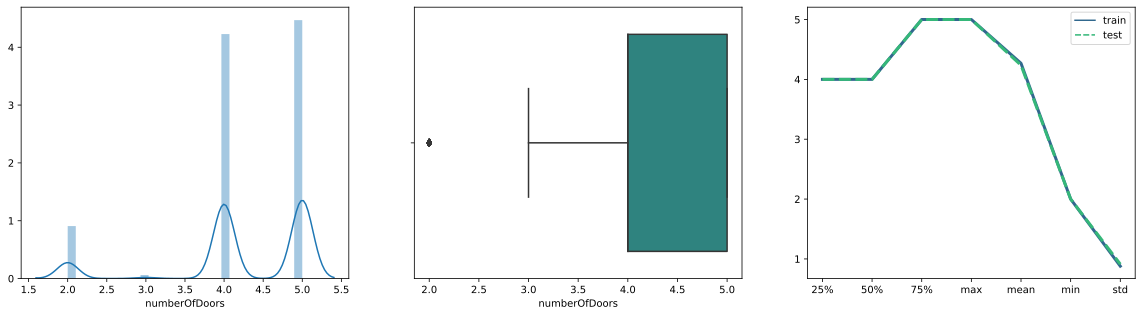

PRICE
mean    1899868.1181
std     1914153.1174
min      301301.0000
25%      800000.0000
50%     1300000.0000
75%     2299283.2500
max    23900000.0000
Name: price, dtype: float64
Кол-во выбросов: 449 	 (%%: 6.72)



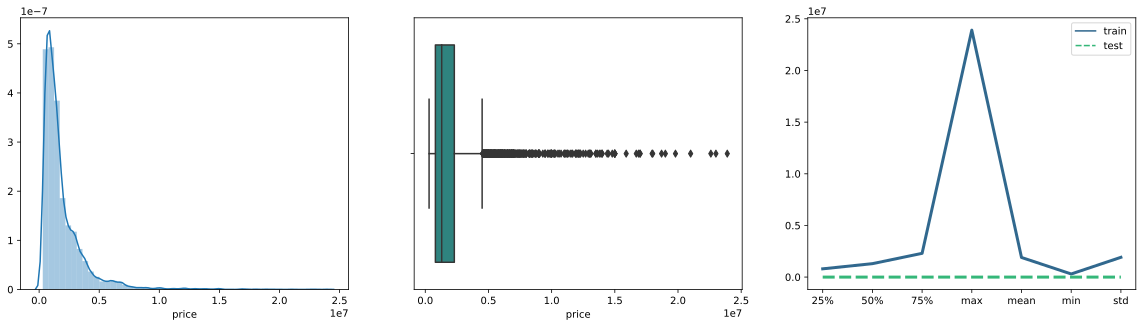

PRODUCTIONDATE
mean   2012.0316
std       5.0497
min    1982.0000
25%    2009.0000
50%    2013.0000
75%    2016.0000
max    2020.0000
Name: productionDate, dtype: float64
Кол-во выбросов: 106 	 (%%: 1.59)



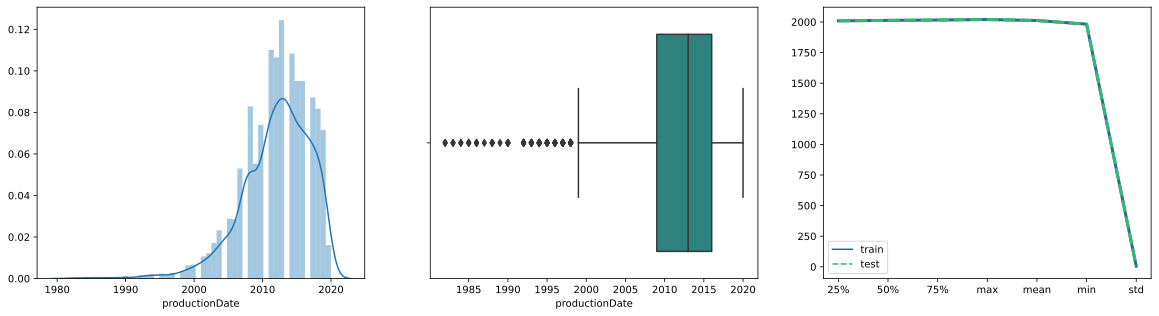

ENG_VOLUME
mean   2.7822
std    1.0638
min    0.0000
25%    2.0000
50%    2.8000
75%    3.0000
max    6.6000
Name: eng_volume, dtype: float64
Кол-во выбросов: 570 	 (%%: 8.53)



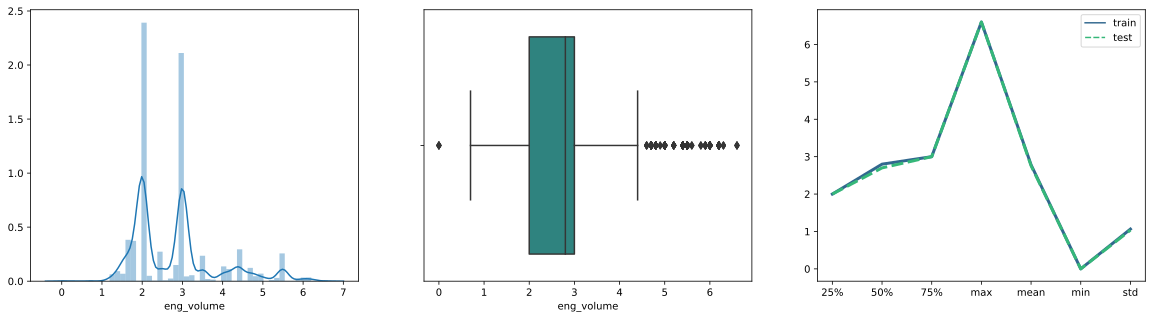

ENG_PWR
mean   255.7887
std    109.2401
min     75.0000
25%    184.0000
50%    231.0000
75%    306.0000
max    639.0000
Name: eng_pwr, dtype: float64
Кол-во выбросов: 402 	 (%%: 6.02)



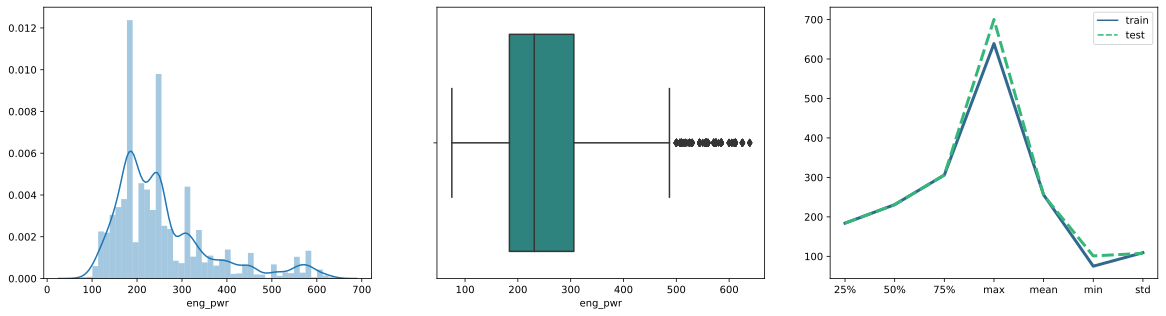

OWN_TIME
mean    16.8423
std     31.4861
min      0.0000
25%      0.0000
50%      0.0000
75%     22.0000
max    334.0000
Name: own_time, dtype: float64
Кол-во выбросов: 792 	 (%%: 11.85)



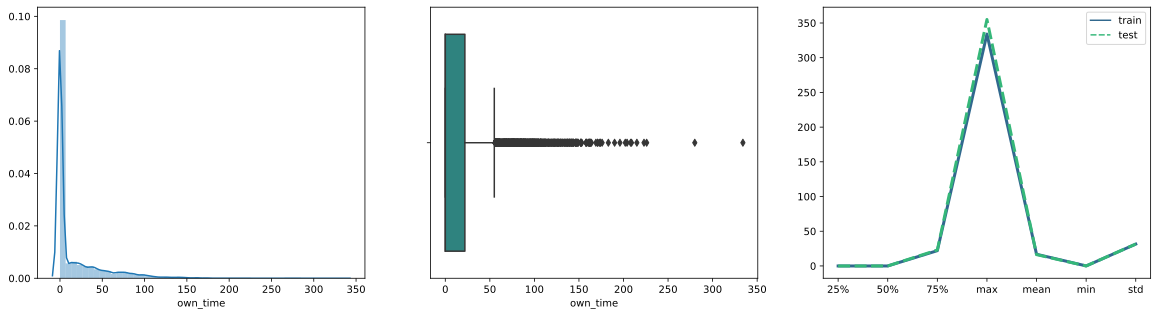

In [36]:
for column in num_cols:
    sum_up_num(data, column, 'price')

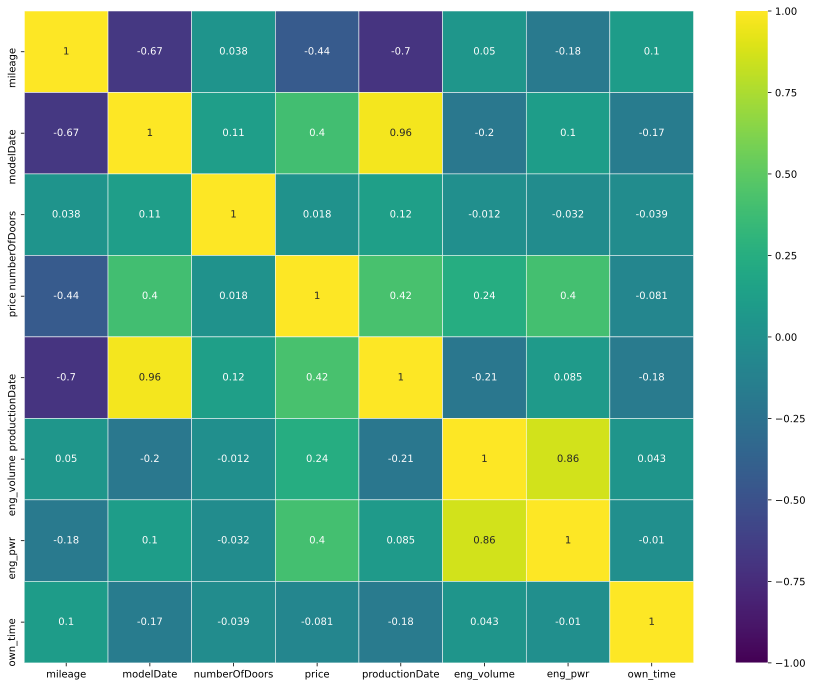

In [37]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1,
            annot=True, linewidths=.5, cmap='viridis')

Признак "numberOfDoors" имеет 4 уникальных значения, отнесем его к категориальному типу.

Признаки "modelDate" и "productionDate" высокоскоррелированы между собой. Их можно привести к лог-нормальному распределению путем вычета из текущего года (2021).

В дальнейшем, для работы с нейросетями, имеет смысл привести признаки к нормальному распределению путем логорифмирования.

NUMBEROFDOORS
5 (%%):	0.46
	 Среднее значение целевой:	2087515.14
4 (%%):	0.44
	 Среднее значение целевой:	1640509.42
2 (%%):	0.09
	 Среднее значение целевой:	2271105.2
3 (%%):	0.01
	 Среднее значение целевой:	602499.98
Cтатистически значимые различия:	True


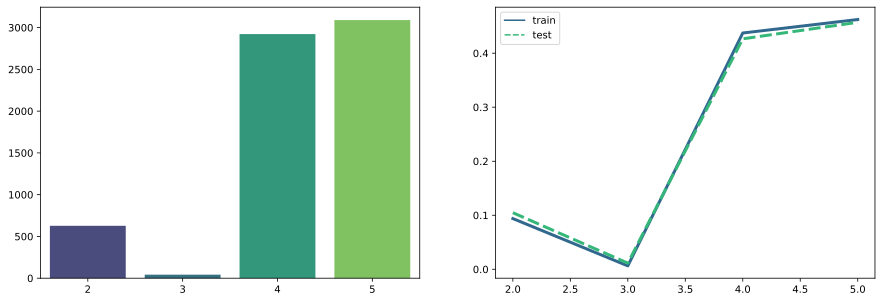

In [38]:
# Перенос признака "numberOfDoors" в категориальные переменные
num_cols.remove('numberOfDoors')
cat_cols.append('numberOfDoors')
sum_up_cat(data, 'numberOfDoors', 'price')

Распределения признака в тренировочной и тестовой выборках схожи.

In [39]:
# Приведем "modelDate" и "prductionDate" к лог-нормальному распределению
for col in ['modelDate', 'productionDate']:
    data[col] = 2021 - data[col]

data.sample(3)

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time
7711,универсал 5 дв.,AUDI,синий,• Автомобиль проверен по 110 пунктам\n• Автокр...,дизель,425554,17,A6,5,0.0000,15,1099543128,механическая,2 владельца,Оригинал,передний,0,2.7000,180,0
6231,внедорожник 5 дв.,BMW,белый,"Бережная эксплуатация, хранение в подземном па...",бензин,56000,7,X4,5,2200000.0000,6,1100023798,автоматическая,1 владелец,Оригинал,полный,1,2.0000,245,64
313,внедорожник 5 дв.,MERCEDES,серый,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,бензин,25637,6,GLE_KLASSE_COUPE_AMG,5,6700000.0000,3,1099919746,автоматическая,1 владелец,Оригинал,полный,1,5.5000,558,0


# Model 2: CatBoost Regressor

In [40]:
# Функция возвращает визуализацию результатов
def plot_results(results, target_metric):
    MMS = MinMaxScaler()
    trans_res = results.T
    scaled_res = pd.DataFrame(MMS.fit_transform(trans_res),
                              columns=trans_res.columns, index=trans_res.index)

    fig, axs = plt.subplots(figsize=(15, 7), gridspec_kw={
                            'height_ratios': [5, 1]}, nrows=2)
    sns.lineplot(x=results.columns, y=results.loc[target_metric].values,
                 marker='o', sort=False, ax=axs[0])
    axs[0].set(ylabel=target_metric, xlabel='ITER')
    sns.lineplot(data=scaled_res, marker='o',
                 sort=False, palette='viridis', ax=axs[1])
    plt.legend(loc='upper left')
    axs[1].set(ylabel='All Metrics', xlabel='ITER')
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

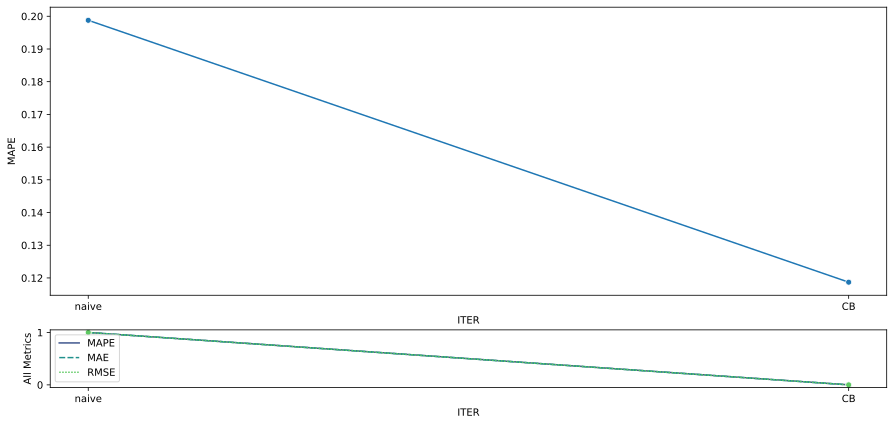

,naive,CB
MAPE,0.1988,0.1187
MAE,347328.2433,226402.5165
RMSE,932296.7579,545908.6151


In [41]:
X = data[data.train == 1].drop(
    ['train', 'description', 'sell_id', 'price'], axis=1)
y = data[data.train == 1]['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
del X, y

for col in tqdm(cat_cols+bin_cols):
    X_train[col].fillna('NS', inplace=True)
    X_test[col].fillna('NS', inplace=True)

CB = CatBoostRegressor(random_seed=RANDOM_SEED, silent=True)
CB.fit(X_train, np.log(y_train+1), cat_features=cat_cols+bin_cols)
CB_preds = CB.predict(X_test)


# Пост-обработка
CB_preds = ((np.exp(CB_preds)-1) // 1000) * 1000

# Расчет и запись метрик
results['CB'] = metrics(y_test, CB_preds)

# Визуализация
plot_results(results, 'MAPE')
results

Значение целевой метрики при использовании CatBoost - 11,87 %

# Feature Engineering

Генерацию признаков возьмем из предыдущего проекта, где полезность признака для модели была протестирована

## Model
Модели авто будут рассмотрены по каждому бренду. Для каждой модели рассчитаем среднеарифметическое стандартизированых средней и максимальной цен. Далее, упорядочиваем модели по статистике внутри бренда и стандартизируем позицию. Таким образом, мы получаем относительное положение модели внутри линейки бренда (самые дорогие авто = 1, самые дешевые = 0).

In [42]:
# Функция возвращает значение, если оно имеется
# В противном случае 'None'
def get_price(df, model):
    try:
        return df[model]
    except:
        return None

In [43]:
# Расчет относительного рейтинга модели
mapping_dict = {}
for mark in tqdm(data.brand.unique()):
    stat = pd.DataFrame(
        {'model': data[data.brand == mark].model_info.unique()})
    stat_max = data[(data.train == 1) & (data.brand == mark)
                    ].groupby('model_info').price.max()
    stat['max_price'] = stat.model.apply(lambda x: get_price(stat_max, x))
    stat_mean = data[(data.train == 1) & (data.brand == mark)
                     ].groupby('model_info').price.mean()
    stat['mean_price'] = stat.model.apply(lambda x: get_price(stat_mean, x))
    max_price_range = stat.max_price.max() - stat.max_price.min()
    mean_price_range = stat.mean_price.max() - stat.mean_price.min()
    stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range
                    + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
    stat['stat'] = stat.stat.fillna(stat.stat.mean())
    stat.sort_values(by='stat', inplace=True)
    stat.reset_index(drop=True, inplace=True)
    stat['ordinal_code'] = stat.index
    stat.stat.fillna(stat.stat.mean())
    for i in stat.index:
        mapping_dict[stat.loc[i]['model']
                     ] = stat.loc[i]['ordinal_code']/stat['ordinal_code'].max()

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
data['rel_model'] = data.model_info.map(mapping_dict)
num_cols.append('rel_model')

REL_MODEL
mean   0.5184
std    0.2412
min    0.0000
25%    0.3333
50%    0.5455
75%    0.6774
max    1.0000
Name: rel_model, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



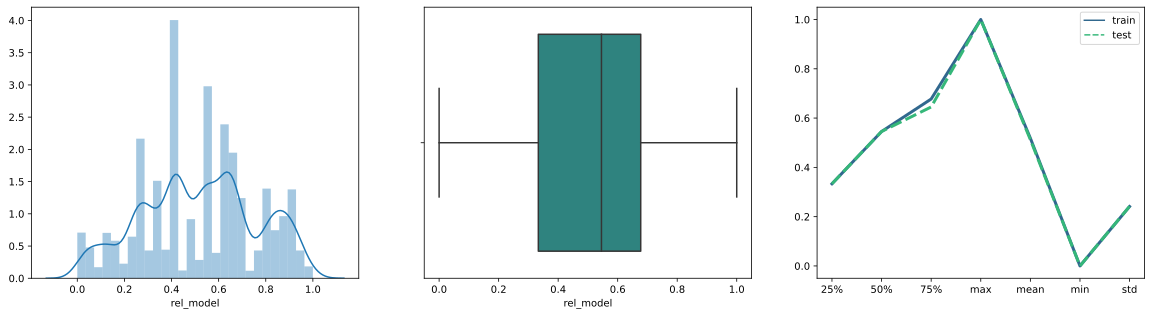

In [45]:
sum_up_num(data, 'rel_model', 'price')

## Decades
Так как зависимость возраста авто и его цены нелинейна (наиболее старые и новые авто дороже), имеет смысл поэксперементировать с разделением времени на отрезки. Несмотря на то,что в градиентный бустинг встроен подобный алгоритм, эксперимент может быть полезен.

In [46]:
data['decade'] = data.productionDate.apply(lambda x: (int(x/10))*10)

In [47]:
stat = pd.DataFrame({'decade': data.decade.unique()})
stat_max = data[data.train == 1].groupby('decade').price.max()
stat['max_price'] = stat.decade.apply(lambda x: get_price(stat_max, x))
stat_avg = data[data.train == 1].groupby('decade').price.mean()
stat['mean_price'] = stat.decade.apply(lambda x: get_price(stat_avg, x))
stat.sort_values(by='decade', inplace=True)
stat.fillna(method='backfill', inplace=True)
max_price_range = stat.max_price.max() - stat.max_price.min()
mean_price_range = stat.mean_price.max() - stat.mean_price.min()
stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range
                + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
stat.sort_values(by='stat', inplace=True)
stat.reset_index(drop=True, inplace=True)
stat['ordinal_code'] = stat.index
stat

,decade,max_price,mean_price,stat,ordinal_code
0,30,3500000.0000,1011470.4583,0.0440,0
1,20,14000000.0000,860804.2079,0.2574,1
2,10,23900000.0000,902848.8920,0.5123,2
3,0,23000000.0000,2573181.7019,0.9779,3


In [48]:
# Добавление параметра
mapping_dict = {}
for i in range(stat.shape[0]):
    mapping_dict[stat.decade.loc[i]] = stat.stat.loc[i]
data['decade'] = data.decade.map(mapping_dict)
num_cols.append('decade')

# Model 2.1: CatBoost + Feature Engineering

In [49]:
# В meta_submission хранятся предсказания моделей
meta_submission = data[data.train == 0][[
    'sell_id']].copy().reset_index(drop=True)


# Функция добавляет предсказания в meta_submission
def submit(preds, ids, prefix='none'):
    submission = sample_submission.copy()
    submission['sell_id'] = ids
    submission['price'] = preds
    global meta_submission
    meta_submission = meta_submission.merge(submission, on='sell_id')
    meta_submission.columns = meta_submission.columns[:-1].to_list()+[prefix]

  0%|          | 0/10 [00:00<?, ?it/s]

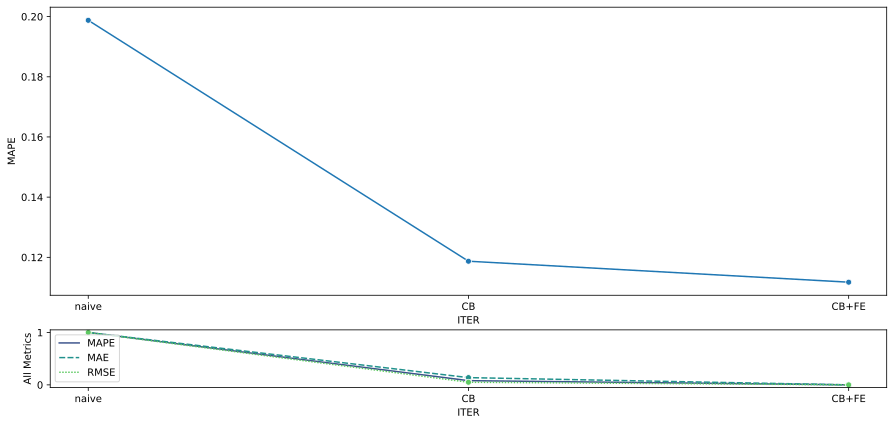

,naive,CB,CB+FE
MAPE,0.1988,0.1187,0.1117
MAE,347328.2433,226402.5165,207045.0389
RMSE,932296.7579,545908.6151,525680.4370


In [51]:
X = data[data.train == 1].drop(
    ['train', 'description', 'sell_id', 'price'], axis=1)
y = data[data.train == 1]['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
del X, y
X_sub = data[data.train == 0].drop(
    ['train', 'description', 'sell_id', 'price'], axis=1)
ids_sub = data[data.train == 0]['sell_id'].values

for col in tqdm(cat_cols+bin_cols):
    X_train[col].fillna('NS', inplace=True)
    X_test[col].fillna('NS', inplace=True)
    X_sub[col].fillna('NS', inplace=True)

CB_FE = CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED,
                       silent=True, eval_metric='MAPE', use_best_model=True)
eval_dataset = Pool(X_test, np.log(y_test+1), cat_features=cat_cols+bin_cols)
CB_FE.fit(X_train, np.log(y_train+1), cat_features=cat_cols +
       bin_cols, eval_set=eval_dataset)
CB_FE_preds = CB_FE.predict(X_test)
CB_FE_sub_preds = CB_FE.predict(X_sub)


# Пост-обработка
CB_FE_preds = ((np.exp(CB_FE_preds)-1) // 1000) * 1000
CB_FE_sub_preds = ((np.exp(CB_FE_sub_preds)-1) // 1000) * 1000

# Расчет и запись метрик
results['CB+FE'] = metrics(y_test, CB_FE_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(CB_FE_sub_preds, ids_sub, prefix='CB+FE')


Добавление признаков улучшило целевую метрику

# Model 3: Tabular NN

Обработаем данные, чтобы подать их на вход нейросети

Этапы обработки:
* Кодирование бинарных переменных (LabelEncoder) 
* Кодирование категориальных признаков (dummy-переменные) 
* Если пропустили NaN в числовых признаках, то заменим их на 0
* Логарифмирование числовых переменных для приведения к нормальному распределению и снижения выбросов, кроме mileage. 
* Стандартизация числовых переменных

In [52]:
# Функция предобработки данных
def processing(df):
    alt_data = df.copy()
    alt_data.reset_index(drop=True, inplace=True)

    LE = LabelEncoder()
    for col in bin_cols:
        alt_data[col] = LE.fit_transform(alt_data[col])

    for col in cat_cols:
        if len(alt_data[col].isna().unique()) > 1:
            alt_data = pd.get_dummies(alt_data, dummy_na=True, columns=[col])
        else:
            alt_data = pd.get_dummies(alt_data, dummy_na=False, columns=[col])

    alt_data.fillna(0.0, inplace=True)

    for col in ['modelDate', 'productionDate', 'eng_volume',
                'eng_pwr', 'own_time', 'rel_model']:
        alt_data[col] = np.log(alt_data[col]+1)

    MMS = MinMaxScaler()
    for col in ['mileage', 'modelDate', 'productionDate',
                'eng_volume', 'eng_pwr', 'own_time',
                'rel_model']:
        alt_data[col] = MMS.fit_transform(alt_data[col].values.reshape(-1, 1))

    return alt_data

In [53]:
processed_data = processing(data)
pd.options.display.max_columns = processed_data.shape[1]
processed_data.sample(3)

,description,mileage,modelDate,price,productionDate,sell_id,ПТС,train,eng_volume,eng_pwr,own_time,rel_model,decade,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,brand_AUDI,brand_BMW,brand_MERCEDES,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_бензин,fuelType_гибрид,fuelType_дизель,fuelType_электро,model_info_100,model_info_1ER,model_info_2ACTIVETOURER,model_info_2ER,model_info_2GRANDTOURER,model_info_3ER,model_info_4,model_info_5ER,model_info_6ER,model_info_7ER,model_info_8ER,model_info_A1,model_info_A3,model_info_A4,model_info_A4_ALLROAD,model_info_A5,model_info_A6,model_info_A7,model_info_A8,model_info_ALLROAD,model_info_AMG_GLC_COUPE,model_info_AMG_GT,model_info_A_KLASSE,model_info_A_KLASSE_AMG,model_info_B_KLASSE,model_info_CITAN,model_info_CLA_KLASSE,model_info_CLA_KLASSE_AMG,model_info_CLC_KLASSE,model_info_CLK_KLASSE,model_info_CLS_KLASSE,model_info_CLS_KLASSE_AMG,model_info_CL_KLASSE,model_info_CL_KLASSE_AMG,model_info_COUPE,model_info_C_KLASSE,model_info_C_KLASSE_AMG,model_info_E_KLASSE,model_info_E_KLASSE_AMG,model_info_GLA_CLASS,model_info_GLA_CLASS_AMG,model_info_GLC_COUPE,model_info_GLC_KLASSE,model_info_GLC_KLASSE_AMG,model_info_GLE_KLASSE,model_info_GLE_KLASSE_AMG,model_info_GLE_KLASSE_COUPE,model_info_GLE_KLASSE_COUPE_AMG,model_info_GLK_KLASSE,model_info_GLS_KLASSE,model_info_GLS_KLASSE_AMG,model_info_GL_KLASSE,model_info_GL_KLASSE_AMG,model_info_G_KLASSE,model_info_G_KLASSE_AMG,model_info_I3,model_info_I8,model_info_M1,model_info_M2,model_info_M3,model_info_M4,model_info_M5,model_info_M6,model_info_M_KLASSE,model_info_M_KLASSE_AMG,model_info_None,model_info_Q3,model_info_Q5,model_info_Q7,model_info_Q8,model_info_R8,model_info_RS3,model_info_RS4,model_info_RS5,model_info_RS6,model_info_RS7,model_info_RSQ3,model_info_R_KLASSE,model_info_S3,model_info_S4,model_info_S5,model_info_S6,model_info_S7,model_info_S8,model_info_SLC_KLASSE,model_info_SLC_KLASSE_AMG,model_info_SLK_KLASSE,model_info_SLK_KLASSE_AMG,model_info_SLR_KLASSE,model_info_SLS_AMG,model_info_SL_KLASSE,model_info_SL_KLASSE_AMG,model_info_SQ5,model_info_SQ7,model_info_S_CLASS_MAYBACH,model_info_S_KLASSE,model_info_S_KLASSE_AMG,model_info_TT,model_info_TTS,model_info_VIANO,model_info_VITO,model_info_V_KLASSE,model_info_W123,model_info_W124,model_info_W201,model_info_X1,model_info_X2,model_info_X3,model_info_X3_M,model_info_X4,model_info_X4_M,model_info_X5,model_info_X5_M,model_info_X6,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Владельцы_1 владелец,Владельцы_2 владельца,Владельцы_3 или более,Владельцы_nan,Привод_задний,Привод_передний,Привод_полный,numberOfDoors_2,numberOfDoors_3,numberOfDoors_4,numberOfDoors_5
205,"Автомобиль куплен у официального дилера, в кон...",0.0134,0.2447,2690000.0000,0.1353,1098026606,1,1,0.5417,0.4148,0.0000,0.6280,0.9779,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
1852,"АУДИ Q5 черный металлик, Полный привод Quattr...",0.1650,0.5437,1194000.0000,0.5372,1099256462,1,1,0.7076,0.5739,0.7804,0.6897,0.9779,0,1,0,0,0

In [54]:
X = processed_data[processed_data.train == 1].drop(
    ['train', 'description', 'sell_id', 'price'], axis=1)
y = processed_data[processed_data.train == 1]['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
del X, y

X_sub = processed_data[processed_data.train == 0].drop(
    ['train', 'description', 'sell_id', 'price'], axis=1)
ids_sub = processed_data[processed_data.train == 0]['sell_id'].values

In [55]:
# Simple model
K.clear_session()
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               95744     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 227,329
Trainable params: 227,329
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [57]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [58]:
# Fit
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                    )


Epoch 00001: saving model to best_model.hdf5

Epoch 00002: saving model to best_model.hdf5

Epoch 00003: saving model to best_model.hdf5

Epoch 00004: saving model to best_model.hdf5

Epoch 00005: saving model to best_model.hdf5

Epoch 00006: saving model to best_model.hdf5

Epoch 00007: saving model to best_model.hdf5

Epoch 00008: saving model to best_model.hdf5

Epoch 00009: saving model to best_model.hdf5

Epoch 00010: saving model to best_model.hdf5

Epoch 00011: saving model to best_model.hdf5

Epoch 00012: saving model to best_model.hdf5

Epoch 00013: saving model to best_model.hdf5

Epoch 00014: saving model to best_model.hdf5

Epoch 00015: saving model to best_model.hdf5

Epoch 00016: saving model to best_model.hdf5

Epoch 00017: saving model to best_model.hdf5

Epoch 00018: saving model to best_model.hdf5

Epoch 00019: saving model to best_model.hdf5

Epoch 00020: saving model to best_model.hdf5

Epoch 00021: saving model to best_model.hdf5

Epoch 00022: saving model to best


Epoch 00180: saving model to best_model.hdf5

Epoch 00181: saving model to best_model.hdf5

Epoch 00182: saving model to best_model.hdf5

Epoch 00183: saving model to best_model.hdf5

Epoch 00184: saving model to best_model.hdf5

Epoch 00185: saving model to best_model.hdf5

Epoch 00186: saving model to best_model.hdf5

Epoch 00187: saving model to best_model.hdf5

Epoch 00188: saving model to best_model.hdf5

Epoch 00189: saving model to best_model.hdf5

Epoch 00190: saving model to best_model.hdf5

Epoch 00191: saving model to best_model.hdf5

Epoch 00192: saving model to best_model.hdf5

Epoch 00193: saving model to best_model.hdf5

Epoch 00194: saving model to best_model.hdf5

Epoch 00195: saving model to best_model.hdf5

Epoch 00196: saving model to best_model.hdf5

Epoch 00197: saving model to best_model.hdf5

Epoch 00198: saving model to best_model.hdf5

Epoch 00199: saving model to best_model.hdf5

Epoch 00200: saving model to best_model.hdf5

Epoch 00201: saving model to best


Epoch 00360: saving model to best_model.hdf5

Epoch 00361: saving model to best_model.hdf5

Epoch 00362: saving model to best_model.hdf5

Epoch 00363: saving model to best_model.hdf5

Epoch 00364: saving model to best_model.hdf5

Epoch 00365: saving model to best_model.hdf5

Epoch 00366: saving model to best_model.hdf5

Epoch 00367: saving model to best_model.hdf5

Epoch 00368: saving model to best_model.hdf5

Epoch 00369: saving model to best_model.hdf5

Epoch 00370: saving model to best_model.hdf5

Epoch 00371: saving model to best_model.hdf5

Epoch 00372: saving model to best_model.hdf5

Epoch 00373: saving model to best_model.hdf5

Epoch 00374: saving model to best_model.hdf5

Epoch 00375: saving model to best_model.hdf5

Epoch 00376: saving model to best_model.hdf5

Epoch 00377: saving model to best_model.hdf5

Epoch 00378: saving model to best_model.hdf5

Epoch 00379: saving model to best_model.hdf5

Epoch 00380: saving model to best_model.hdf5

Epoch 00381: saving model to best

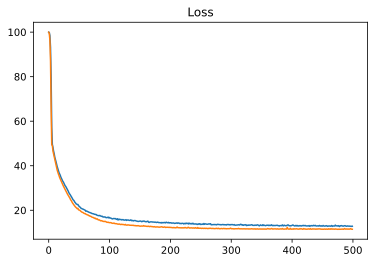

In [59]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [60]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

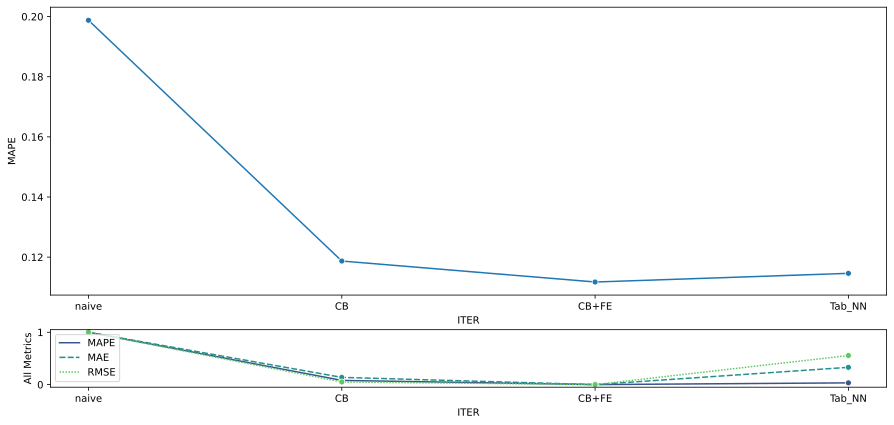

,naive,CB,CB+FE,Tab_NN
MAPE,0.1988,0.1187,0.1117,0.1146
MAE,347328.2433,226402.5165,207045.0389,253332.4287
RMSE,932296.7579,545908.6151,525680.4370,751555.4117


In [61]:
nn_preds = model.predict(X_test)
nn_preds = nn_preds.reshape(1, -1)[0]
nn_sub_preds = model.predict(X_sub)
nn_sub_preds = nn_sub_preds.reshape(1, -1)[0]

# Пост-обработка
nn_preds = (nn_preds // 1000) * 1000
nn_sub_preds = (nn_sub_preds // 1000) * 1000

# Расчет и запись метрик
results['Tab_NN'] = metrics(y_test, nn_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(nn_sub_preds, ids_sub, prefix='Tab_NN')

Нейросеть показывает результаты хуже, чем CatBoost, но, тем не менее, достаточно хорошие

# Model 4: Tabular NN + проброс

Определим наиболее важные признаки на примере CatBoost

In [65]:
data.head()

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time,rel_model,decade
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,бензин,245000,14,5ER,4,599000.0000,14,1099980990,автоматическая,3 или более,Оригинал,полный,1,3.0000,272,0,0.5455,0.5123
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",бензин,183000,10,A6,4,850000.0000,10,1095836906,вариатор,2 владельца,Оригинал,передний,1,2.8000,204,102,0.6452,0.5123
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,бензин,122733,12,E_KLASSE,4,1325000.0000,8,1100195530,автоматическая,3 или более,Оригинал,полный,1,3.5000,306,0,0.4182,0.9779
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,бензин,151000,10,A6,4,815000.0000,10,1099880662,вариатор,3 или более,Оригинал,передний,1,2.0000,180,57,0.6452,0.5123
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",бензин,140000,14,A5,5,810000.0000,10,1083244610,вариатор,3 или более,Оригинал,передний,1,1.8000,160,33,0.4839,0.5123


In [67]:
# Функция возвращает важность переменных для модели
def get_feature_importance(data, target, model=CatBoostRegressor(random_seed = RANDOM_SEED, silent=True)):
    df = data.copy()
    
    # Кодирование
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if df[col].dtype == object:
            df[col] = df[col].fillna('Non_specified')
            df[col] = df[col].apply(lambda x: str(x))
            df[col] = LE.fit_transform(df[col])
    
    # Разделение переменных
    cols = df[sorted(bin_cols+cat_cols+num_cols)].drop(['price'], axis=1).columns
    X = df[sorted(bin_cols+cat_cols+num_cols)].drop(['price'], axis=1).values
    y = df[target].values
    
    # Расчет важности переменных
    model.fit(X, np.log(y))
    FE = pd.Series(model.get_feature_importance(), index=cols).sort_values(ascending=False)
    
    # Визуализация
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x=FE.values, y=FE.index, palette = 'viridis')
    ax.set(ylabel='FEATURE', xlabel='RELATIVE IMPORTANCE (%%)')
    plt.show()
    display(pd.DataFrame(FE, columns=['score']).T)

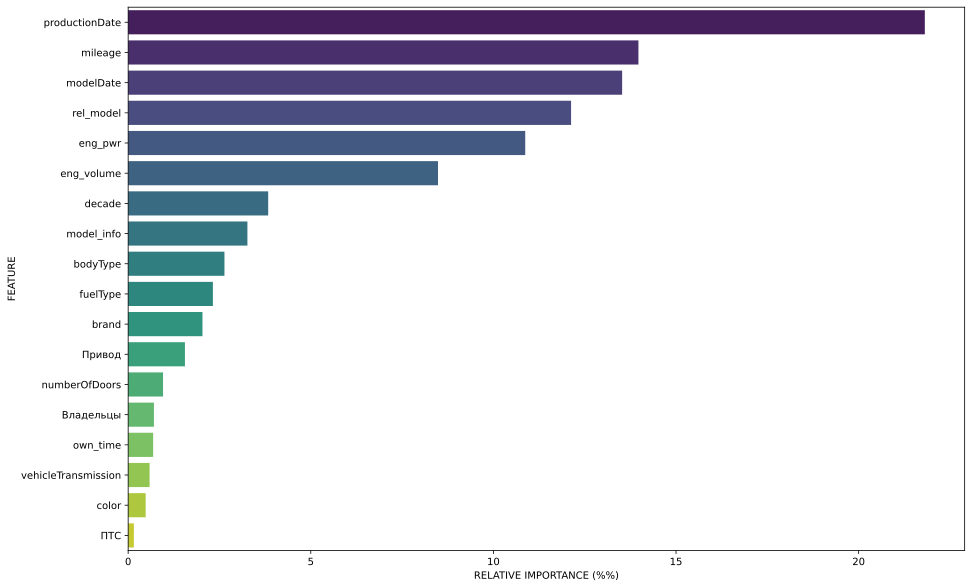

,productionDate,mileage,modelDate,rel_model,eng_pwr,eng_volume,decade,model_info,bodyType,fuelType,brand,Привод,numberOfDoors,Владельцы,own_time,vehicleTransmission,color,ПТС
score,21.8117,13.9704,13.5244,12.1265,10.8713,8.4831,3.8336,3.2651,2.6366,2.3198,2.0343,1.5547,0.9551,0.7059,0.6844,0.5870,0.4795,0.1567


In [68]:
get_feature_importance(data[data.train==1], 'price')

Признак "productionDate" наиболее важен для модели. Попробуем сделать проброс этого признака.

In [69]:
K.clear_session()
tf.random.set_seed(RANDOM_SEED)

# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [70]:
# FEATURE Input
# Input
productiondate = L.Input(shape=[1], name="productionDate")

# Embeddings layers
emb_productiondate = L.Embedding(
    len(data.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [73]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, ])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

nn_pass_model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [74]:
nn_pass_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 186)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          95744       dense_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
productionDate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [75]:
optimizer = tf.keras.optimizers.Adam(0.01)
nn_pass_model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [76]:
history = nn_pass_model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=(
                        [X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
11/12 [==========================>...] - ETA: 0s - loss: 99.9852 - MAPE: 99.9852
Epoch 00001: saving model to best_model.hdf5
12/12 [==============================] - 0s 21ms/step - loss: 99.9843 - MAPE: 99.9843 - val_loss: 99.8207 - val_MAPE: 99.8207
Epoch 2/500
11/12 [==========================>...] - ETA: 0s - loss: 98.4723 - MAPE: 98.4723
Epoch 00002: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 98.4321 - MAPE: 98.4321 - val_loss: 93.0511 - val_MAPE: 93.0511
Epoch 3/500
11/12 [==========================>...] - ETA: 0s - loss: 78.0840 - MAPE: 78.0840
Epoch 00003: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 77.8710 - MAPE: 77.8710 - val_loss: 50.0796 - val_MAPE: 50.0796
Epoch 4/500
11/12 [==========================>...] - ETA: 0s - loss: 52.2519 - MAPE: 52.2519
Epoch 00004: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 52.2194 

Epoch 32/500
11/12 [==========================>...] - ETA: 0s - loss: 17.4468 - MAPE: 17.4468
Epoch 00032: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 17.4518 - MAPE: 17.4518 - val_loss: 15.7109 - val_MAPE: 15.7109
Epoch 33/500
11/12 [==========================>...] - ETA: 0s - loss: 17.4612 - MAPE: 17.4612
Epoch 00033: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 17.4547 - MAPE: 17.4547 - val_loss: 15.4404 - val_MAPE: 15.4404
Epoch 34/500
11/12 [==========================>...] - ETA: 0s - loss: 17.0738 - MAPE: 17.0738
Epoch 00034: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 17.0623 - MAPE: 17.0623 - val_loss: 15.2857 - val_MAPE: 15.2857
Epoch 35/500
11/12 [==========================>...] - ETA: 0s - loss: 17.1249 - MAPE: 17.1249
Epoch 00035: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 17.1

Epoch 63/500
10/12 [========================>.....] - ETA: 0s - loss: 14.5298 - MAPE: 14.5298
Epoch 00063: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 14.6028 - MAPE: 14.6028 - val_loss: 12.6169 - val_MAPE: 12.6169
Epoch 64/500
11/12 [==========================>...] - ETA: 0s - loss: 14.8792 - MAPE: 14.8792
Epoch 00064: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 14.8693 - MAPE: 14.8693 - val_loss: 12.7178 - val_MAPE: 12.7178
Epoch 65/500
11/12 [==========================>...] - ETA: 0s - loss: 14.6725 - MAPE: 14.6725
Epoch 00065: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 14.6672 - MAPE: 14.6672 - val_loss: 12.7221 - val_MAPE: 12.7221
Epoch 66/500
11/12 [==========================>...] - ETA: 0s - loss: 14.5508 - MAPE: 14.5508
Epoch 00066: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 14.5

Epoch 94/500
11/12 [==========================>...] - ETA: 0s - loss: 13.7055 - MAPE: 13.7055
Epoch 00094: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 13.6968 - MAPE: 13.6968 - val_loss: 12.1297 - val_MAPE: 12.1297
Epoch 95/500
10/12 [========================>.....] - ETA: 0s - loss: 13.6375 - MAPE: 13.6375
Epoch 00095: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 13.5769 - MAPE: 13.5769 - val_loss: 11.9320 - val_MAPE: 11.9320
Epoch 96/500
11/12 [==========================>...] - ETA: 0s - loss: 13.6320 - MAPE: 13.6320
Epoch 00096: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 13.6104 - MAPE: 13.6104 - val_loss: 11.8836 - val_MAPE: 11.8836
Epoch 97/500
11/12 [==========================>...] - ETA: 0s - loss: 13.5878 - MAPE: 13.5878
Epoch 00097: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 13.5

Epoch 125/500
11/12 [==========================>...] - ETA: 0s - loss: 13.2285 - MAPE: 13.2285
Epoch 00125: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 13.2242 - MAPE: 13.2242 - val_loss: 11.8026 - val_MAPE: 11.8026
Epoch 126/500
11/12 [==========================>...] - ETA: 0s - loss: 13.1693 - MAPE: 13.1693
Epoch 00126: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 13.1707 - MAPE: 13.1707 - val_loss: 11.8242 - val_MAPE: 11.8242
Epoch 127/500
11/12 [==========================>...] - ETA: 0s - loss: 13.1676 - MAPE: 13.1676
Epoch 00127: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 13.1567 - MAPE: 13.1567 - val_loss: 11.8769 - val_MAPE: 11.8769
Epoch 128/500
11/12 [==========================>...] - ETA: 0s - loss: 13.1767 - MAPE: 13.1767
Epoch 00128: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 

Epoch 156/500
11/12 [==========================>...] - ETA: 0s - loss: 12.9247 - MAPE: 12.9247
Epoch 00156: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 12.9117 - MAPE: 12.9117 - val_loss: 12.0701 - val_MAPE: 12.0701
Epoch 157/500
11/12 [==========================>...] - ETA: 0s - loss: 12.8286 - MAPE: 12.8286
Epoch 00157: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 12.8364 - MAPE: 12.8364 - val_loss: 11.8133 - val_MAPE: 11.8133
Epoch 158/500
11/12 [==========================>...] - ETA: 0s - loss: 12.7032 - MAPE: 12.7032
Epoch 00158: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 12.7284 - MAPE: 12.7284 - val_loss: 11.7785 - val_MAPE: 11.7785
Epoch 159/500
10/12 [========================>.....] - ETA: 0s - loss: 12.7296 - MAPE: 12.7296
Epoch 00159: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 

Epoch 187/500
11/12 [==========================>...] - ETA: 0s - loss: 12.3061 - MAPE: 12.3061
Epoch 00187: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 12.3136 - MAPE: 12.3136 - val_loss: 11.6846 - val_MAPE: 11.6846
Epoch 188/500
11/12 [==========================>...] - ETA: 0s - loss: 12.3762 - MAPE: 12.3762
Epoch 00188: saving model to best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 12.4181 - MAPE: 12.4181 - val_loss: 11.7804 - val_MAPE: 11.7804
Epoch 189/500
11/12 [==========================>...] - ETA: 0s - loss: 12.3918 - MAPE: 12.3918
Epoch 00189: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 12.3775 - MAPE: 12.3775 - val_loss: 11.7165 - val_MAPE: 11.7165
Epoch 190/500
11/12 [==========================>...] - ETA: 0s - loss: 12.4139 - MAPE: 12.4139
Epoch 00190: saving model to best_model.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 

Epoch 218/500
10/12 [========================>.....] - ETA: 0s - loss: 11.9894 - MAPE: 11.9894
Epoch 00218: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11.9850 - MAPE: 11.9850 - val_loss: 11.5520 - val_MAPE: 11.5520
Epoch 219/500
11/12 [==========================>...] - ETA: 0s - loss: 11.7697 - MAPE: 11.7697
Epoch 00219: saving model to best_model.hdf5
12/12 [==============================] - 0s 19ms/step - loss: 11.7748 - MAPE: 11.7748 - val_loss: 11.6952 - val_MAPE: 11.6952
Epoch 220/500
 9/12 [=====================>........] - ETA: 0s - loss: 11.9154 - MAPE: 11.9154
Epoch 00220: saving model to best_model.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 11.9662 - MAPE: 11.9662 - val_loss: 11.7461 - val_MAPE: 11.7461
Epoch 221/500
11/12 [==========================>...] - ETA: 0s - loss: 11.8341 - MAPE: 11.8341
Epoch 00221: saving model to best_model.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 

Epoch 249/500
10/12 [========================>.....] - ETA: 0s - loss: 11.5644 - MAPE: 11.5644
Epoch 00249: saving model to best_model.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 11.5356 - MAPE: 11.5356 - val_loss: 11.4417 - val_MAPE: 11.4417
Epoch 250/500
11/12 [==========================>...] - ETA: 0s - loss: 11.6968 - MAPE: 11.6968
Epoch 00250: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11.6954 - MAPE: 11.6954 - val_loss: 11.5095 - val_MAPE: 11.5095
Epoch 251/500
11/12 [==========================>...] - ETA: 0s - loss: 11.5223 - MAPE: 11.5223
Epoch 00251: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11.5173 - MAPE: 11.5173 - val_loss: 11.5704 - val_MAPE: 11.5704
Epoch 252/500
11/12 [==========================>...] - ETA: 0s - loss: 11.4982 - MAPE: 11.4982
Epoch 00252: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 

Epoch 280/500
11/12 [==========================>...] - ETA: 0s - loss: 11.3803 - MAPE: 11.3803
Epoch 00280: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11.3766 - MAPE: 11.3766 - val_loss: 11.5498 - val_MAPE: 11.5498
Epoch 281/500
10/12 [========================>.....] - ETA: 0s - loss: 11.2533 - MAPE: 11.2533
Epoch 00281: saving model to best_model.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 11.2397 - MAPE: 11.2397 - val_loss: 11.5670 - val_MAPE: 11.5670
Epoch 282/500
11/12 [==========================>...] - ETA: 0s - loss: 11.1793 - MAPE: 11.1793
Epoch 00282: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11.1714 - MAPE: 11.1714 - val_loss: 11.7713 - val_MAPE: 11.7713
Epoch 283/500
11/12 [==========================>...] - ETA: 0s - loss: 11.4251 - MAPE: 11.4251
Epoch 00283: saving model to best_model.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 

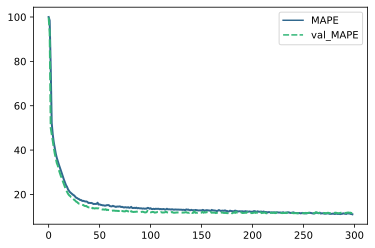

In [77]:
sns.lineplot(data=pd.DataFrame({'MAPE': history.history['MAPE'], 'val_MAPE': history.history['val_MAPE']}),
             palette='viridis', linewidth=2)

In [78]:
nn_pass_model.load_weights('best_model.hdf5')
test_predict_nn_pass = nn_pass_model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_pass[:,0]))*100:0.2f}%")

TEST mape: 11.69%


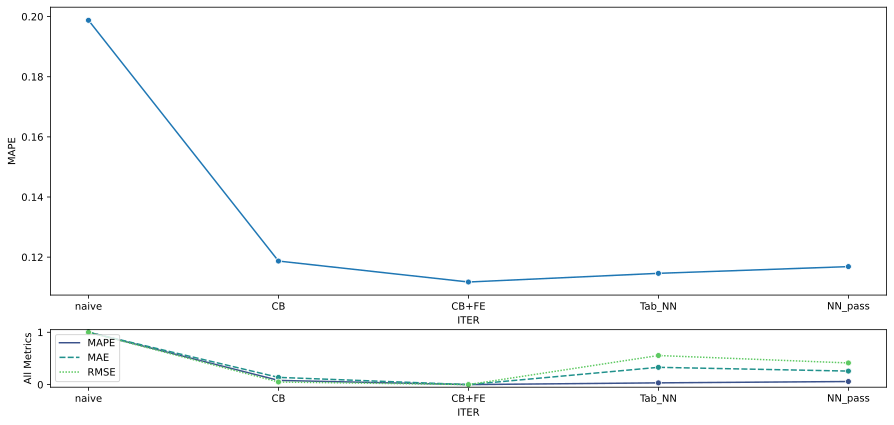

,naive,CB,CB+FE,Tab_NN,NN_pass
MAPE,0.1988,0.1187,0.1117,0.1146,0.1169
MAE,347328.2433,226402.5165,207045.0389,253332.4287,243264.8534
RMSE,932296.7579,545908.6151,525680.4370,751555.4117,693933.5175


In [79]:
nn_pass_preds = nn_pass_model.predict(
    [X_test, X_test.productionDate.values, X_test.mileage.values])
nn_pass_preds = nn_pass_preds.reshape(1, -1)[0]
nn_pass_sub_preds = nn_pass_model.predict(
    [X_sub, X_sub.productionDate.values, X_sub.mileage.values])
nn_pass_sub_preds = nn_pass_sub_preds.reshape(1, -1)[0]

# Пост-обработка
nn_pass_preds = (nn_pass_preds // 1000) * 1000
nn_pass_sub_preds = (nn_pass_sub_preds // 1000) * 1000

# Расчет и запись метрик
results['NN_pass'] = metrics(y_test, nn_pass_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(nn_pass_sub_preds, ids_sub, prefix='NN_pass')

Нейросеть с пробросом признака "productionDate" показывает результат хуже, чем обычная нейросеть. Проброс признака использовать не будем.

# Model 5: NLP

## Предобработка

In [80]:
processed_data.description

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8348    Продаётся любимица семьи. Автомобилем неактивн...
8349    В продаже автомобиль от компании АО ABTODOM, о...
8350    Машина в идеальном техническом состоянии. Обсл...
8351    Автомобиль приобретался новым у дилера Avilon ...
8352    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8353, dtype: object

In [81]:
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer(language="russian")

# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [82]:
# Функция возвращает обработанный текст
# Удаляет стоп-слова, проводит стемминг

def process_text(text):
    # Осталяем только слова и числа
    cleaned_text = re.sub('[^А-Яа-я0-9]+', ' ', text).lower()
    tokens = nltk.word_tokenize(cleaned_text)
    filtered_text = [word for word in tokens if word not in stop_words]
    stemmed_text = [stemmer.stem(word) for word in filtered_text]
    text = " ".join(stemmed_text)

    return text

In [83]:
print(data.loc[1110]['description'])
print()
print(process_text(data.loc[1110]['description']))


Машина - сказка!
Одной рукой рулишь, другой слезу от счастья вытираешь!
Она в прекрасном рабочем состоянии. Ухожена и обласкана, как любимая женщина. Всё у неё в идеале. 
На 200000 по мотору подошёл регламент. Были выполнены все регламентные работы: заменены маслосъёмные колпачки, ваносы, цепи, натяжители цепей, башмаки. Заменены масла, фильтра, тормозная жидкость. Любая проверка у офицалов (за ваш счёт).
Автомобиль в постоянной эксплуатации. Звоните. Отвечу на все ваши вопросы. 
Без косяков. Без торга! Цена окончательная!

Господа! Если вас смущает реальный пробег моего автомобиля, могу скрутить его до 100 тысяч. И будет как у всех:)

Меняюсь только на Деньги! Либо с вашей доплатой! В рассрочку не продаю!

машин сказк одн рук рул слез счаст вытира прекрасн рабоч состоян ухож обласка любим женщин вс идеал 200000 мотор подош л регламент выполн регламентн работ замен маслос мны колпачк ванос цеп натяжител цеп башмак замен масл фильтр тормозн жидкост люб проверк офицал ваш сч т автомобил

In [84]:
processed_data['description'] = processed_data.description.progress_apply(
    process_text)
processed_data.description

  0%|          | 0/8353 [00:00<?, ?it/s]

0       авт бодр ход работа отличн электрик ходов акпп...
1       продаж собственник втор владелец птс оригина о...
2       вниман клиент автомоб пробег предлага специаль...
3       комплект зимн кол са 27 07 2020 зам передн тор...
4       отличн авт 2011 год выпуск кром передн лев кры...
                              ...                        
8348    прод тся любимиц сем автомобил неактивн пользо...
8349    продаж автомобил компан а официальн дилер цвет...
8350    машин идеальн техническ состоян обслуживан ауд...
8351    автомобил приобрета нов дилер октябр 2013 год ...
8352    38887 комплектац год выпуск птс 2014г комплект...
Name: description, Length: 8353, dtype: object

In [85]:
# split данных
text_train = processed_data.description.iloc[X_train.index]
text_test = processed_data.description.iloc[X_test.index]
text_sub = processed_data.description.iloc[X_sub.index]

In [86]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(processed_data.description)

In [87]:
len(tokenize.word_index)

16370

In [88]:
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape)

(5679, 256) (1003, 256) (1671, 256)


In [89]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобил провер 110 пункт автокред специальн ставк 13 7 ауд центр север официальн дилер входя групп компан рольф явля одн крупн дилер европ предлага ряд услуг покупк продаж автомобил пробег протяжен мног лет наш дилерск центр явля лидер продаж автомобил пробег сред дилер росс предоставля клиент сам больш выбор автомобил пробег друг марок кажд автомобил проход тщательн диагностик подготовк гарантирова наход отличн состоян убед правильн выбор возможн пройт тест драйв ознакомительн поездк интерес автомобил сможет ознаком автомобил выход дом наш менеджер проведет презентац видеозвонк покажет выбра автомобил такж ауд центр север представля уникальн предложен кредитован автомобил пробег индивидуальн услов специалист компан подберут лучш услов кредитован 6 000 проверен автомобил пробег гарант 2 лет ждут сайт мобильн приложен рольф
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

## RNN NLP

In [90]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

## MLP

In [91]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

## Multiple Inputs NN

In [92]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

NLP_model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [93]:
NLP_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     4190976     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

## Fit

In [94]:
optimizer = tf.keras.optimizers.Adam(0.01)
NLP_model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [95]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [96]:
history = NLP_model.fit([text_train_sequences, X_train], y_train,
                        batch_size=512,
                        epochs=500,
                        validation_data=(
                            [text_test_sequences, X_test], y_test),
                        callbacks=callbacks_list
                        )

Epoch 1/500
12/12 [==============================] - 77s 6s/step - loss: 99.9870 - MAPE: 99.9870 - val_loss: 99.8430 - val_MAPE: 99.8430
Epoch 2/500
12/12 [==============================] - 96s 8s/step - loss: 98.5292 - MAPE: 98.5292 - val_loss: 93.3814 - val_MAPE: 93.3814
Epoch 3/500
12/12 [==============================] - 112s 9s/step - loss: 78.5003 - MAPE: 78.5003 - val_loss: 50.3269 - val_MAPE: 50.3269
Epoch 4/500
12/12 [==============================] - 125s 10s/step - loss: 52.4134 - MAPE: 52.4134 - val_loss: 47.4327 - val_MAPE: 47.4327
Epoch 5/500
12/12 [==============================] - 130s 11s/step - loss: 46.9172 - MAPE: 46.9172 - val_loss: 44.3813 - val_MAPE: 44.3813
Epoch 6/500
12/12 [==============================] - 135s 11s/step - loss: 43.9084 - MAPE: 43.9084 - val_loss: 41.2889 - val_MAPE: 41.2889
Epoch 7/500
12/12 [==============================] - 138s 11s/step - loss: 40.8567 - MAPE: 40.8567 - val_loss: 38.5502 - val_MAPE: 38.5502
Epoch 8/500
12/12 [=============

12/12 [==============================] - 155s 13s/step - loss: 13.8284 - MAPE: 13.8284 - val_loss: 12.8896 - val_MAPE: 12.8896
Epoch 60/500
12/12 [==============================] - 154s 13s/step - loss: 14.0415 - MAPE: 14.0415 - val_loss: 12.7351 - val_MAPE: 12.7351
Epoch 61/500
12/12 [==============================] - 154s 13s/step - loss: 13.8544 - MAPE: 13.8544 - val_loss: 12.6347 - val_MAPE: 12.6347
Epoch 62/500
12/12 [==============================] - 154s 13s/step - loss: 13.6853 - MAPE: 13.6853 - val_loss: 12.5911 - val_MAPE: 12.5911
Epoch 63/500
12/12 [==============================] - 154s 13s/step - loss: 13.6637 - MAPE: 13.6637 - val_loss: 12.5873 - val_MAPE: 12.5873
Epoch 64/500
12/12 [==============================] - 155s 13s/step - loss: 13.7811 - MAPE: 13.7811 - val_loss: 12.5888 - val_MAPE: 12.5888
Epoch 65/500
12/12 [==============================] - 154s 13s/step - loss: 13.7222 - MAPE: 13.7222 - val_loss: 12.6395 - val_MAPE: 12.6395
Epoch 66/500
12/12 [=============

12/12 [==============================] - 156s 13s/step - loss: 12.4502 - MAPE: 12.4502 - val_loss: 12.1731 - val_MAPE: 12.1731
Epoch 118/500
12/12 [==============================] - 156s 13s/step - loss: 13.1624 - MAPE: 13.1624 - val_loss: 11.7193 - val_MAPE: 11.7193
Epoch 119/500
12/12 [==============================] - 156s 13s/step - loss: 12.3371 - MAPE: 12.3371 - val_loss: 11.6635 - val_MAPE: 11.6635
Epoch 120/500
12/12 [==============================] - 155s 13s/step - loss: 12.3396 - MAPE: 12.3396 - val_loss: 11.8086 - val_MAPE: 11.8086
Epoch 121/500
12/12 [==============================] - 156s 13s/step - loss: 12.4231 - MAPE: 12.4231 - val_loss: 11.7235 - val_MAPE: 11.7235
Epoch 122/500
12/12 [==============================] - 156s 13s/step - loss: 12.2859 - MAPE: 12.2859 - val_loss: 11.7174 - val_MAPE: 11.7174
Epoch 123/500
12/12 [==============================] - 154s 13s/step - loss: 12.1888 - MAPE: 12.1888 - val_loss: 11.7715 - val_MAPE: 11.7715
Epoch 124/500
12/12 [======

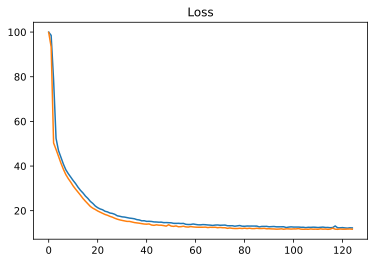

In [97]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [98]:
NLP_model.load_weights('best_model.hdf5')
NLP_model.save('nn_mlp_nlp.hdf5')

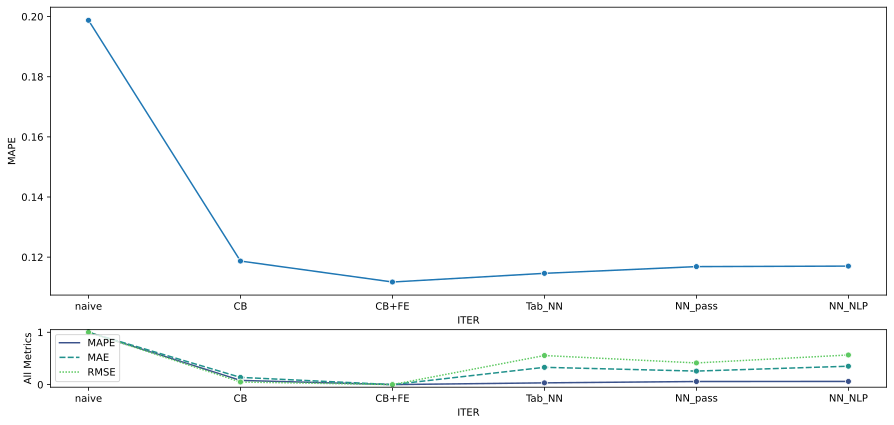

,naive,CB,CB+FE,Tab_NN,NN_pass,NN_NLP
MAPE,0.1988,0.1187,0.1117,0.1146,0.1169,0.1170
MAE,347328.2433,226402.5165,207045.0389,253332.4287,243264.8534,256301.7448
RMSE,932296.7579,545908.6151,525680.4370,751555.4117,693933.5175,755712.7757


In [99]:
nn_nlp_preds = NLP_model.predict([text_test_sequences, X_test])
nn_nlp_preds = nn_nlp_preds.reshape(1, -1)[0]
nn_nlp_sub_preds = NLP_model.predict([text_sub_sequences, X_sub])
nn_nlp_sub_preds = nn_nlp_sub_preds.reshape(1, -1)[0]

# Пост-обработка
nn_nlp_preds = (nn_nlp_preds // 1000) * 1000
nn_nlp_sub_preds = (nn_nlp_sub_preds // 1000) * 1000

# Расчет и запись метрик
results['NN_NLP'] = metrics(y_test, nn_nlp_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(nn_nlp_sub_preds, ids_sub, prefix='NN_NLP')


Добавление текста в нейросеть слегка ухудшило метрику

# Model 6: CV

## Data

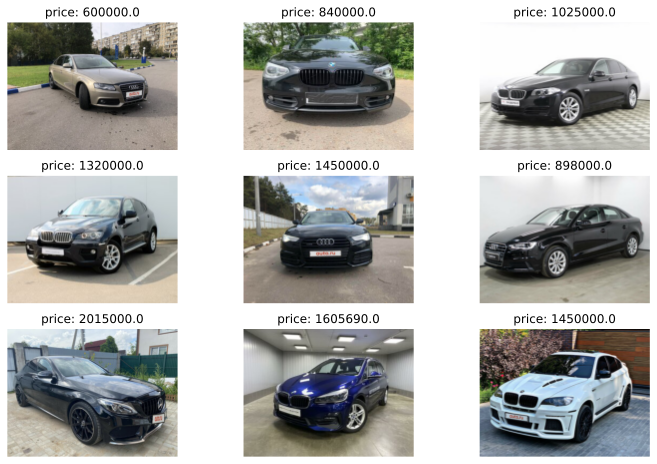

In [100]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [101]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread('img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


## Albumentation

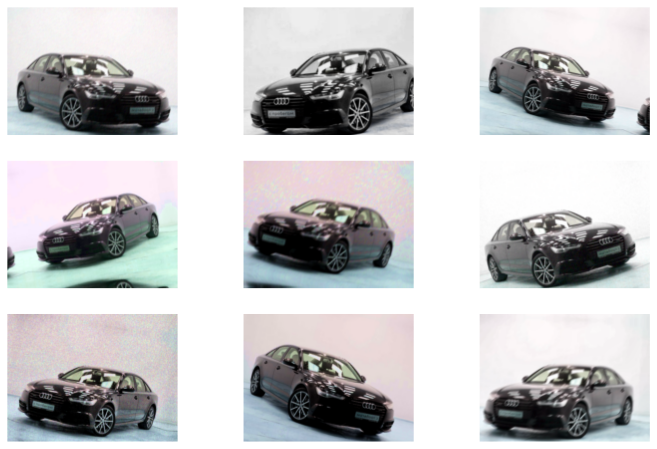

In [102]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[6])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [103]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [104]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train_sequences, y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test_sequences, y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub_sequences, y_sub
)).map(tf_process_val_dataset_element)

### Строим сверточную сеть для анализа изображений без "головы"

In [105]:
# нормализация включена в состав модели EfficientNetB6, поэтому на вход она принимает данные типа uint8
K.clear_session()
tf.random.set_seed(RANDOM_SEED)


efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

efficientnet_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [106]:
# строим нейросеть для анализа табличных данных

model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               95744     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
Total params: 227,072
Trainable params: 227,072
Non-trainable params: 0
_________________________________________________________________


In [107]:
# NLP

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(16371, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

model_nlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 256)          4190976   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

In [108]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, model_mlp.output, model_nlp.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

CV_model = Model(inputs=[efficientnet_model.input,
                      model_mlp.input, model_nlp.input], outputs=head)
CV_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

Total params: 46,781,136
Trainable params: 46,556,697
Non-trainable params: 224,439
__________________________________________________________________________________________________


In [109]:
optimizer = tf.keras.optimizers.Adam(0.05)
CV_model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [110]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [111]:
# history = CV_model.fit(train_dataset.batch(20),
#                     epochs=60,
#                     validation_data=test_dataset.batch(20),
#                     callbacks=callbacks_list
#                     )

Не получается обучить сеть, не хватает мощности на домашнем компьютере. А на Каггле все падает на этапе наивной модели, видимо, какие-то нюансы версий сказываются. Прошу понять и простить. Вернусь к этому вопросу позже.

In [112]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [113]:
# CV_model.load_weights('best_model.hdf5')
# CV_model.save('nn_final.hdf5')

In [114]:
# test_predict_nn3 = CV_model.predict(test_dataset.batch(30))
# print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [115]:
# sub_predict_nn3 = CV_model.predict(sub_dataset.batch(30))
# sample_submission['price'] = sub_predict_nn3[:,0]
# sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

Так как нейросеть с изображениями обучить не удалось, сделаем блендинг с нейросетью, обученной на табличных данных и описании

In [116]:
blend_predict = (CB_FE_preds + nn_nlp_preds) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")


TEST mape: 10.76%


In [117]:
blend_sub_predict = (CB_FE_sub_preds + nn_nlp_sub_preds) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)                     

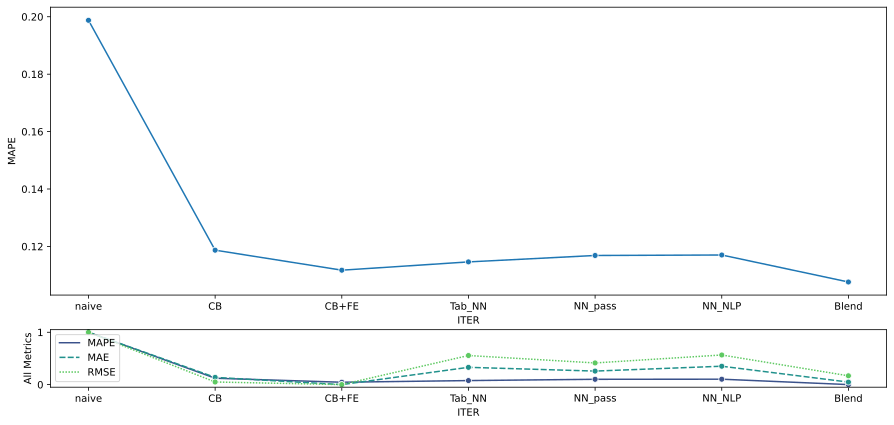

,naive,CB,CB+FE,Tab_NN,NN_pass,NN_NLP,Blend
MAPE,0.1988,0.1187,0.1117,0.1146,0.1169,0.1170,0.1076
MAE,347328.2433,226402.5165,207045.0389,253332.4287,243264.8534,256301.7448,213800.0499
RMSE,932296.7579,545908.6151,525680.4370,751555.4117,693933.5175,755712.7757,594052.6341


In [118]:
# Расчет и запись метрик
results['Blend'] = metrics(y_test, blend_predict)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(blend_sub_predict, ids_sub, prefix='Blend')



Блэндинг показал наилучший результат, MAPE = 10.76%

Посмотрим результаты предсказаний по всем моделям и сохраним файлы с предсказанием для каждой модели.

In [119]:
meta_submission.sample(3)

,sell_id,CB+FE,Tab_NN,NN_pass,NN_NLP,Blend
830,1099054080,2611000.0000,2721000.0000,2692000.0000,2785000.0000,2698000.0000
1172,1096177412,844000.0000,787000.0000,961000.0000,883000.0000,863500.0000
241,1092432196,7487000.0000,6322000.0000,6987000.0000,6250000.0000,6868500.0000


In [120]:
for col in meta_submission.columns[1:]:
    submission = sample_submission.copy()
    submission['sell_id'] = meta_submission.sell_id.values
    submission['price'] = meta_submission[col].values
    submission.to_csv('{}_submission.csv'.format(col), index=False)

**Выводы**
1. На тренировочной выборке лучше всего сработал блэндинг CatBoost и нейросети, на вход которой подаются табличные данные и текст
2. На тестовой выборке также лучшие результаты показал блэндинг. На тестовой выборке MAPE = 11.35%
3. Из моделей лучшие результаты получены для CatBoost: MAPE = 11.85%
4. Нейросеть (табличные данные + текст) показала результат хуже, чем просто CatBoost